# Predict StackOverflow tags

Stack Overflow is a site that every programmer uses one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. 

The task here is to use questions (title and body) to predict tags. This is a multilabel classification task.

**Multi-label Classification:** Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. 

**The Data:** Data used is found on Kaggle as 'StackSample: 10% of Stack Overflow Q&A' through the following link: https://www.kaggle.com/stackoverflow/stacksample/data

This is a dataset with the text of 10% of questions and answers from the Stack Overflow programming Q&A website.

This is organized as three tables - Questions, Answers and Tags. Here, only two will be used:
+ Questions contains the title, body, creation date, closed date (if applicable), score, and owner ID for all non-deleted Stack Overflow questions whose Id is a multiple of 10.
+ Tags contains the tags on each of these questions

The task is to use questions to predict tags. This is a multilabel classification task.

Three methods will be used:
1. Bag of Words
2. TF-IDF
3. RNN

In order to limit computing power required, only the title will be used to train the model and predict the tags (previous versions combined title and question, but runtime was extremely long).

**Performance metrics**   

Given that this is a multiclass classification problem, where we want to predit as many tags as possible with high precision and recall, F1 score can be used as it only give a good value if both precision and recall are high. As F1 performs well for binary classification, in a multilabel setting, this can be modified.

Micro-Averaged F1-Score (Mean F Score):        
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In the multiclass and multilabel case, this is the weighted average of the F1 score of each class.

'Micro f1 score':    
Calculates metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance. This takes the tag frequency of occurrence into consideration when it is computing the micro precision and recall.

'Macro f1 score':    
Calculates metrics for each label, and find their unweighted mean. This does not take label imbalance into account, therefore is not preferred when some tags occur a lot of times and others occur few times.

Hamming loss:     
The Hamming loss is the fraction of labels that are incorrectly predicted. 

I will use this opportunity to practice using sql to store and extract data.

In [1]:
import numpy as np 
import pandas as pd 

#for counting
import collections

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings("ignore")
import sqlite3
import csv
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottefettes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading and cleaning the data
### Combining Questions.csv and Tags.csv

In [ ]:
tags = pd.read_csv('data/Tags.csv',encoding='iso-8859-1')

def add_tags(question_id):
    return tags[tags['Id'] == question_id['Id']].Tag.values

print(tags.head())

tag_com = tags.apply(add_tags, axis=1)

#add tags list to tags df
tags = pd.concat([tags, tag_com.rename('Tags')], axis=1)

#remove individual tag column and duplicate question id rows
tags.drop(["Tag"], axis=1, inplace=True)
tags = tags.loc[tags.astype(str).drop_duplicates().index]

ques = pd.read_csv('data/Questions.csv', encoding='iso-8859-1')
data = pd.merge(ques, tags, on='Id')

data.to_csv('data/Train.csv')

### Creating db from csv

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('data/Train.csv', names=['Id', 'OwnerUserId','CreationDate','ClosedDate','Score', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [3]:
#counting number of rows
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 1264217
Time taken to count the number of rows : 0:00:00.756967


In [4]:
#checking for duplicates
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:00:23.558420


In [5]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 2 ( 0.00015820068864913495 % )


In [6]:
# number of times each question appeared in database
df_no_dup.cnt_dup.value_counts()

1    1264213
2          2
Name: cnt_dup, dtype: int64

In [7]:
df_no_dup.shape

(1264215, 4)

In [8]:
#any null values
df_no_dup.isnull().sum()

Title      0
Body       0
Tags       0
cnt_dup    0
dtype: int64

In [9]:
#check datatypes
df_no_dup.dtypes

Title      object
Body       object
Tags       object
cnt_dup     int64
dtype: object

In [10]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",['jsp' 'jstl'],1
1,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,['java' 'jdbc'],1
2,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,['php' 'forms'],1
3,jtable reloads but when clicked on a jcheck ...,<p>i) My Table contains no of columns and a jc...,['java' 'swing' 'jtable'],1
4,"""subquery returns more than 1 row"" error.",<p>I am new to web programming and I'm trying ...,['sql' 'subquery'],1


In [11]:
start = datetime.now()

#count number of tags in tags list for each row
df_no_dup["tag_count"] = df_no_dup["Tags"].str.split(" ").str.len()

# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:02.361423


,Title,Body,Tags,cnt_dup,tag_count
0,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",['jsp' 'jstl'],1,2
1,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,['java' 'jdbc'],1,2
2,"""SQL Injection"" issue preventing correct for...",<p>So I've been checking everything I can thin...,['php' 'forms'],1,2
3,jtable reloads but when clicked on a jcheck ...,<p>i) My Table contains no of columns and a jc...,['java' 'swing' 'jtable'],1,3
4,"""subquery returns more than 1 row"" error.",<p>I am new to web programming and I'm trying ...,['sql' 'subquery'],1,2


In [12]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    367668
2    326804
4    254224
5    165491
1    150028
Name: tag_count, dtype: int64

In [13]:
#Creating new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train', disk_dup)

In [14]:
#creating tags df
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()

    #drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)

    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:14.085630


In [15]:
tag_data["Tags"] = tag_data["Tags"].replace(' ', ',', regex=True)
tag_data['Tags'] = tag_data['Tags'].str.strip('[]')
tag_data['Tags'] = tag_data['Tags'].str.strip("''")
tag_data['Tags'] = tag_data['Tags'].str.replace("','", ' ')

## Data Exploration - analysis of tags

In [16]:
#create lists of all tags and all unique tags
all_tags = list(tag_data['Tags'].str.split(' ', expand=True).stack())
tag_dtm = list(tag_data['Tags'].str.split(' ', expand=True).stack().unique())

In [17]:
print("Number of unique tags :", len(tag_dtm))
print("Some of the tags we have :", tag_dtm[:10])

Number of unique tags : 47005
Some of the tags we have : ['java', 'jdbc', 'php', 'forms', 'swing', 'jtable', 'sql', 'subquery', 'c#', 'javascript']


In [18]:
#create dictionary giving frequency of all unique tags
tag_count = dict(collections.Counter(list(all_tags)))

In [19]:
#Saving dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in tag_count.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,java,115160
1,jdbc,2123
2,php,98796
3,forms,7585
4,swing,6462


In [20]:
#sort tags from most to least frequent
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

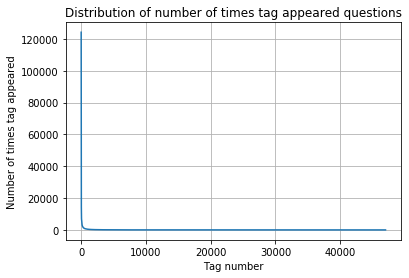

In [21]:
#plot frequency of all tags
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

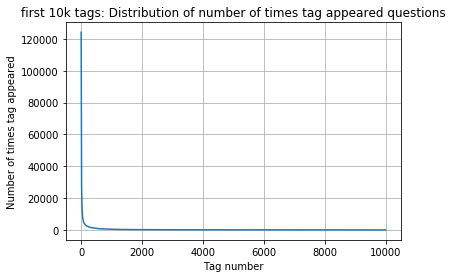

In [22]:
#plot frequency of 10,000 most common tags
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

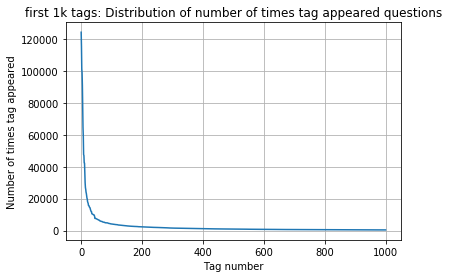

In [23]:
#plot frequency of 1,000 most common tags
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

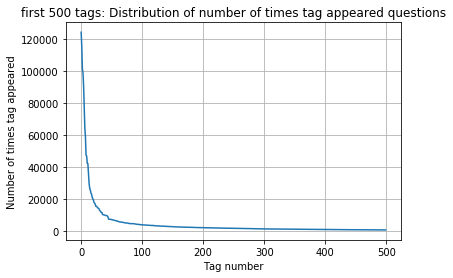

In [24]:
#plot frequency of 500 most common tags
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

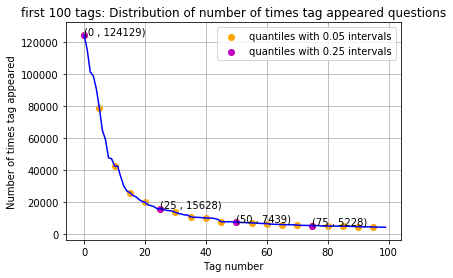

In [25]:
#plot frequency of 100 most common tags
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [26]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))
# Store tags equal to 1 in one list
lst_tags_gt_1 = tag_df[tag_df.Counts==1].Tags
#Print the length of the list.
print ('{} Tags are used only once'.format(len(lst_tags_gt_1)))
# Store tags less than 5 in one list
lst_tags_gt_5 = tag_df[tag_df.Counts<5].Tags
#Print the length of the list.
print ('{} Tags are used less than 5 times'.format(len(lst_tags_gt_5)))

40 Tags are used more than 10000 times
3 Tags are used more than 100000 times
15714 Tags are used only once
25950 Tags are used less than 5 times


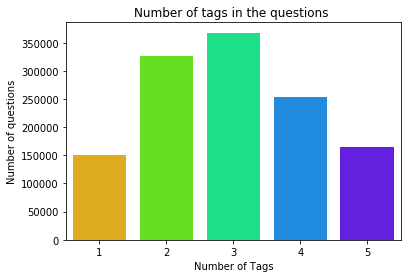

In [27]:
#distribution of number of tags per question
sns.countplot(df_no_dup.tag_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

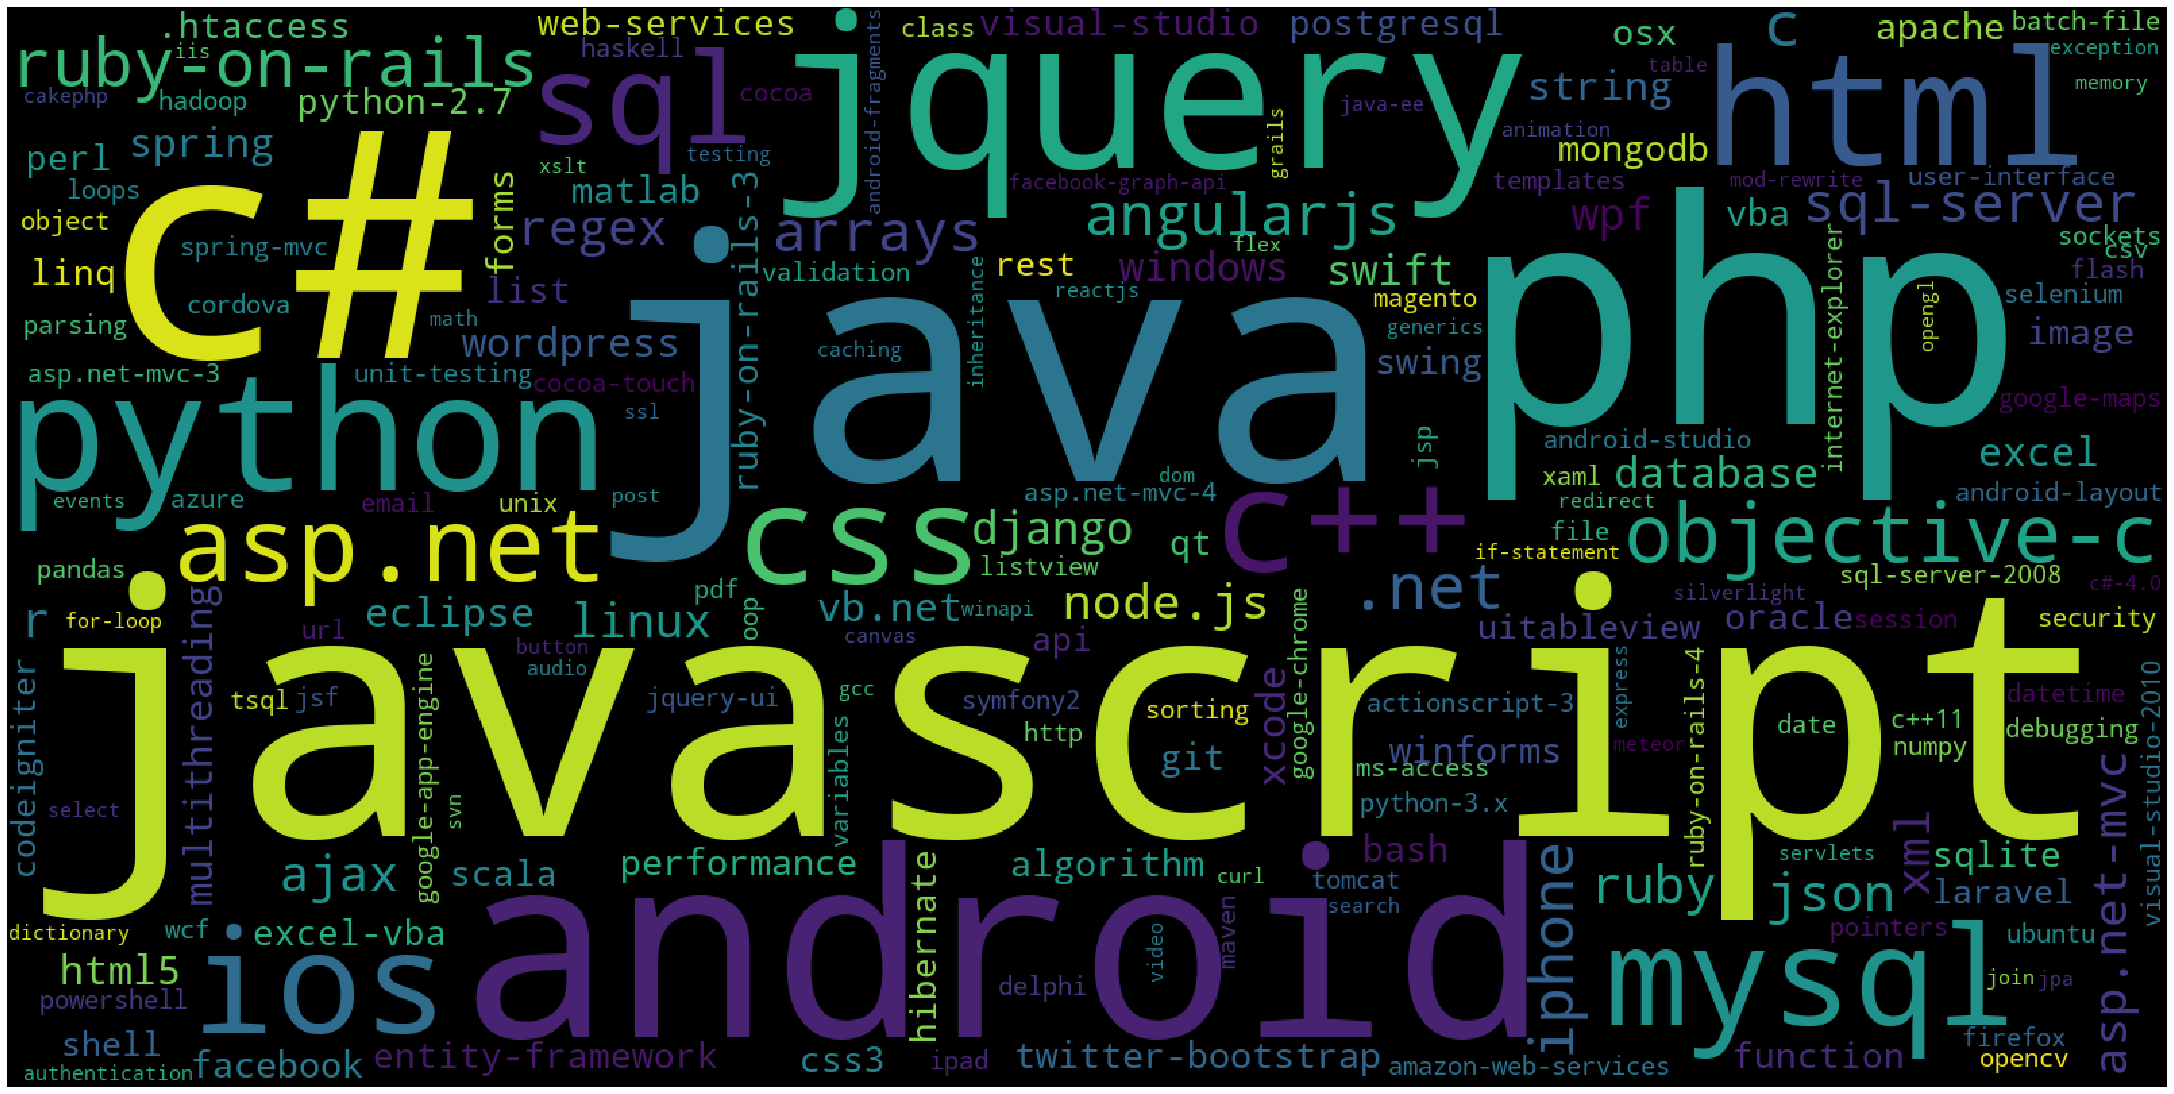

Time taken to run this cell : 0:00:03.060582


In [28]:
# Plotting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(tag_count.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

From the above exploration, of the 42049 unique tags:
+ 40 tags are used more than 10,000 times
+ 3 tags are used more than 100,000 times
+ 15,714 tags are used only once
+ Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the most appropriate metric for this problem.
+ In order to cut down on computing power, only the most common tags and their corresponding questions will be taken forward for use in building a model and predicting tags - to decide on the number, later the proportion of questions at least partially covered by number of tags selected will be ascertained
+ The majority of questions have 2 or 3 tags - however this may change when tags are filtered to retaining only the most common

## Prepare the data
### Preprocess questions

In [29]:
def rem_html_tags(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [30]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (title text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [31]:
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM();")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:09.585802


In [32]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_processed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in title:
        questions_with_code+=1
        is_code = 1
    #x = len(question)+len(title)
    x = len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', title, flags=re.DOTALL))

    title = re.sub('<code>(.*?)</code>', '', title, flags=re.MULTILINE|re.DOTALL)
    #question = rem_html_tags(question.encode('utf-8'))

    #title = title.encode('utf-8')
    title = title.lower()
    title = REPLACE_BY_SPACE_RE.sub(' ', title) # replace REPLACE_BY_SPACE_RE symbols by space in text
    title = BAD_SYMBOLS_RE.sub(' ', title) # delete symbols which are in BAD_SYMBOLS_RE from text
    title = ' '.join([x for x in title.split() if x and x not in stop_words and (len(x)!=1 or x=='c')]) # delete stopwords from text

    #combine title and body
    #question = str(title)+" "+str(question)
    #question = question.lower()
    #question = REPLACE_BY_SPACE_RE.sub(' ', question) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #question = BAD_SYMBOLS_RE.sub(' ', question) # delete symbols which are in BAD_SYMBOLS_RE from text
    #question = ' '.join([x for x in question.split() if x and x not in stop_words and (len(x)!=1 or x=='c')]) # delete stopwords from text
    
    #question=re.sub(r'[^A-Za-z]+',' ',question)
    #words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question except for letter 'c'
    #question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(title)
    tup = (title,code,tags,x,len(title))
    questions_processed += 1
    writer.execute("insert into QuestionsProcessed(title,code,tags,words_pre,words_post) values (?,?,?,?,?)",tup)
    if (questions_processed%100000==0):
        print("number of questions completed =",questions_processed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_processed
no_dup_avg_len_post=(len_post*1.0)/questions_processed

print( "Avg. length of questions(Title) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_processed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed = 100000
number of questions completed = 200000
number of questions completed = 300000
number of questions completed = 400000
number of questions completed = 500000
number of questions completed = 600000
number of questions completed = 700000
number of questions completed = 800000
number of questions completed = 900000
number of questions completed = 1000000
number of questions completed = 1100000
number of questions completed = 1200000
Avg. length of questions(Title) before processing: 51
Avg. length of questions(Title) after processing: 40
Percent of questions containing code: 0
Time taken to run this cell : 0:00:23.770594


In [33]:
# close connections
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [34]:
#show sample of processed titles
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        reader.execute("SELECT title From QuestionsProcessed LIMIT 10")
        print("Title after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Title after preprocessed
('retaining form values post part model',)
----------------------------------------------------------------------------------------------------
('wpf translating xaml animation c# code',)
----------------------------------------------------------------------------------------------------
('keep form top another',)
----------------------------------------------------------------------------------------------------
('gitattributes file converting line endings',)
----------------------------------------------------------------------------------------------------
('cannot view stored procedure body visual studio',)
----------------------------------------------------------------------------------------------------
('learn iphone jailbroken programming',)
----------------------------------------------------------------------------------------------------
('install old xml package source windows',)
---------------------------------------------------------------------

In [35]:
#Taking entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT title, tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [36]:
preprocessed_data["tags"] = preprocessed_data["tags"].replace(' ', ',', regex=True)
preprocessed_data['tags'] = preprocessed_data['tags'].str.strip('[]')
preprocessed_data['tags'] = preprocessed_data['tags'].str.strip("''")
preprocessed_data['tags'] = preprocessed_data['tags'].str.replace("','", ' ')

In [37]:
#split tags per question into list
preprocessed_data['tags_split'] = preprocessed_data['tags'].str.split(" ")
preprocessed_data.head()

,title,tags,tags_split
0,htmlencode string javascript,javascript,[javascript]
1,retaining form values post part model,asp.net-mvc-4 entity-framework-5,"[asp.net-mvc-4, entity-framework-5]"
2,wpf translating xaml animation c# code,c# wpf animation,"[c#, wpf, animation]"
3,keep form top another,vb.net,[vb.net]
4,gitattributes file converting line endings,git vim centos phpstorm,"[git, vim, centos, phpstorm]"


In [38]:
preprocessed_data['tags_split_str'] = preprocessed_data['tags_split'].apply(str)

# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags_split_str'])

In [39]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [40]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

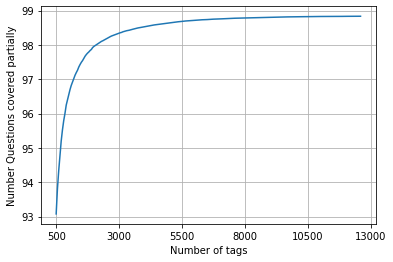

with  5000 tags covered at least partially  98.275 % of questions
with  1000 tags covered at least partially  95.527 % of questions
with  500 covered at least partially  93.079 % of questions


In [41]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions covered partially")
plt.grid()
plt.show()

# find questions explained by number of tags
print("with ", 5000,"tags covered at least partially ",questions_explained[45],"% of questions")
print("with ", 1000,"tags covered at least partially ",questions_explained[5],"% of questions")
print("with ", 500,"covered at least partially ",questions_explained[0],"% of questions")

As the most common 1000 tags covers just over 95% of the questions, this will be the number of tags retained - it means reduction in the data is minimised. 

Given that tags are being removed, tags per question predicted will likely only be partial - the model cannot predict tags that it was not trained to predict. Therefore, based on the original data the model will not perform as well as metrics may claim it does. 

In [42]:
#top 1000 tags
top1000 = tag_df_sorted[:1000]
top1000_tags = list(top1000.Tags)

In [43]:
#replace tags per question will filtered tags per question
tags_lst = preprocessed_data['tags_split']
tags_lst2 = []
for i in tags_lst:
    lst = []
    for j in i:
        if j in top1000_tags:
            lst.append(j)
    tags_lst2.append(lst)
    
preprocessed_data['tags_filtered'] = tags_lst2
preprocessed_data.head()

,title,tags,tags_split,tags_split_str,tags_filtered
0,htmlencode string javascript,javascript,[javascript],['javascript'],[javascript]
1,retaining form values post part model,asp.net-mvc-4 entity-framework-5,"[asp.net-mvc-4, entity-framework-5]","['asp.net-mvc-4', 'entity-framework-5']",[asp.net-mvc-4]
2,wpf translating xaml animation c# code,c# wpf animation,"[c#, wpf, animation]","['c#', 'wpf', 'animation']","[c#, wpf, animation]"
3,keep form top another,vb.net,[vb.net],['vb.net'],[vb.net]
4,gitattributes file converting line endings,git vim centos phpstorm,"[git, vim, centos, phpstorm]","['git', 'vim', 'centos', 'phpstorm']","[git, vim, centos]"


In [44]:
#find number of questions that will be filtered out as it corresponds to none of the tags in the top 1000
len(preprocessed_data[preprocessed_data.astype(str)['tags_filtered'] == '[]'])

48386

In [46]:
#remove rows where tags_filtered is empty list
preprocessed_data = preprocessed_data[preprocessed_data.astype(str)['tags_filtered'] != '[]']

#retain wanted columns
preprocessed_data = preprocessed_data[['title','tags','tags_filtered']]

In [47]:
preprocessed_data.isnull().sum()

title            0
tags             0
tags_filtered    0
dtype: int64

## Modelling for prediction

Mulitple approaches will be used here:    
+ Bag-of-words
+ TF-IDF
+ RNN

For the first 2, a classifier will be trained. A one-vs-rest approach will be used, where k classifiers (# tags) are trained. Logistic Regression will be used. This is a simple classifier - possibly not the best performed, but should perform fairly well on text classification.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU ,concatenate
from keras.models import Model

Using TensorFlow backend.


In [49]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(preprocessed_data.tags_filtered)
labels = multilabel_binarizer.classes_
labels

array(['.htaccess', '.net', '.net-3.5', '.net-4.0', '2d', '3d', '64bit',
       'access-vba', 'actionscript', 'actionscript-3', 'active-directory',
       'activerecord', 'admob', 'ado.net', 'air', 'ajax', 'akka',
       'algorithm', 'alignment', 'amazon-ec2', 'amazon-s3',
       'amazon-web-services', 'android', 'android-actionbar',
       'android-activity', 'android-asynctask', 'android-camera',
       'android-edittext', 'android-emulator', 'android-fragments',
       'android-gradle', 'android-intent', 'android-layout',
       'android-listview', 'android-ndk', 'android-studio',
       'android-viewpager', 'android-webview', 'android-widget',
       'angular-ui-router', 'angular2', 'angularjs',
       'angularjs-directive', 'angularjs-ng-repeat', 'angularjs-scope',
       'animation', 'annotations', 'ant', 'apache', 'apache-camel',
       'apache-pig', 'apache-poi', 'apache-spark', 'apache2', 'api',
       'app-store', 'append', 'apple-push-notifications', 'applescript',
       'a

### Split data into train and test sets

In [50]:
train, test = train_test_split(preprocessed_data, train_size = 0.8, random_state=42)

In [51]:
train.shape, test.shape

((972662, 3), (243166, 3))

In [52]:
X_train = train['title']
y_train = train['tags_filtered']
X_test = test['title']
y_test = test['tags_filtered']

In [53]:
#transform y sets with mlb
y_train_mlb = multilabel_binarizer.transform(train['tags_filtered'])
y_test_mlb = multilabel_binarizer.transform(test['tags_filtered'])

### Prepare classifier

In [54]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [55]:
def train_classifier(X_train, y_train, penalty='l2', C=1.0):
    # Create and fit LogisticRegression wrapped into OneVsRestClassifier.
    lr = LogisticRegression(penalty=penalty, C=C, solver='liblinear')
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

## Modelling Approach 1: Bag of words and Logistic Regression with OneVsRest Classifier

Bag-of-words representation will be used to convert the text data to numeric vectors. To do this, the following steps will be taken:
1. Find N most popular words in training corpus and numerate them, creating a dictionary containing the most popular words.
2. For each title in the corpora, create a zero vector with dimension equal to N.
3. For each text in the corpora, iterate over words that are in the dictionary and increase by 1 the corresponding coordinate.

Only the title column (X_train_t and X_test_t) will be used for prediction here.

In [56]:
#word tag counts
from collections import Counter

# Dictionary of all tags from train corpus with their counts.
tags_counts = Counter()

# Dictionary of all words from train corpus with their counts.
words_counts = Counter()

for tags in y_train:
    for tag in tags:
        tags_counts[tag] += 1
        
for words in X_train:
    for word in words.split():
        words_counts[word] += 1
        
        
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print('Most common tags: ', most_common_tags)
print('Most common words: ', most_common_words)

Most common tags:  [('javascript', 99314), ('java', 92101), ('c#', 81083)]
Most common words:  [('using', 71619), ('file', 42453), ('error', 39240)]


In [57]:
DICT_SIZE = 5000
INDEX_TO_WORDS = sorted(words_counts.keys(), key=lambda x: words_counts[x], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {word:i for i, word in enumerate(INDEX_TO_WORDS)}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):

    result_vector = np.zeros(dict_size)

    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector

In [58]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print(test_my_bag_of_words())

Basic tests are passed.


In [59]:
from scipy import sparse as sp_sparse

In [60]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])

print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (972662, 5000)
X_test shape  (243166, 5000)


The data has been transformed into a sparse representation for efficient storage. As sklearn algorithms can only work with csr matrix, this is used here.

In [61]:
#train classifier for bag-of-words data transformation
classifier_mybag = train_classifier(X_train_mybag, y_train_mlb)

In [62]:
#create predictions for the data - 2 types: labels and scores
y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)
y_test_predicted_scores_mybag = classifier_mybag.decision_function(X_test_mybag)

## Modelling Approach 2: TF-IDF and Logistic Regression with OneVsRest Classifier

As an alternative approach, the bag-of-words framework can be extended by taking into account total frequencies of words in the corpora, which helps to penalise too-frequent words, and provides better features space.

The vectoriser is trained using the train corpus.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
def tfidf_features(X_train, X_test):
    # create TF-IDF vectorizer, fit on train set, transform train and test sets and return the result
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), token_pattern='(\S+)')
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_test, tfidf_vectorizer.vocabulary_

In [65]:
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [66]:
#check results
print(tfidf_vocab['python'])
print(tfidf_vocab['c'])

111101
17013


In [67]:
#train classifier for tf-idf data transformation
classifier_tfidf = train_classifier(X_train_tfidf, y_train_mlb)

In [68]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
y_test_predicted_scores_tfidf = classifier_tfidf.decision_function(X_test_tfidf)

In [69]:
#examples of how TF-IDF classifier works
y_test_pred_inversed = multilabel_binarizer.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test_mlb)
indices = [5,7]
for i in indices:
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	cannot view stored procedure body visual studio
True labels:	login,vb.net
Predicted labels:	html,javascript,jquery


Title:	install old xml package source windows
True labels:	mysql
Predicted labels:	mysql




## Modelling Approach 3: Deep Learning using Recurrent Neural Network (RNN)

In [70]:
import nltk
nltk.download('punkt')
    
sent_lens = []
for sent in train['title']:
    sent_lens.append(len(word_tokenize(sent)))
max(sent_lens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/charlottefettes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


24

In [74]:
np.quantile(sent_lens, 0.90)

9.0

In [75]:
max_len = 24
tok = Tokenizer(char_level=False, split=' ')
tok.fit_on_texts(X_train)
sequences_train = tok.texts_to_sequences(X_train)

In [76]:
vocab_len = len(tok.index_word.keys())
vocab_len

115601

In [77]:
sequences_matrix_train = sequence.pad_sequences(sequences_train, maxlen = max_len)
sequences_matrix_train

array([[    0,     0,     0, ..., 35853, 14205,    20],
       [    0,     0,     0, ...,   790,  1923,    12],
       [    0,     0,     0, ...,  2614,   374,    38],
       ...,
       [    0,     0,     0, ...,    45,   199,    79],
       [    0,     0,     0, ...,    85,    85,    39],
       [    0,     0,     0, ...,     1,    66,     5]], dtype=int32)

In [78]:
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen = max_len)

In [79]:
sequences_matrix_train.shape, y_train_mlb.shape

((972662, 24), (972662, 1000))

In [80]:
sequences_matrix_test.shape, sequences_matrix_test.shape, y_test_mlb.shape

((243166, 24), (243166, 24), (243166, 1000))

In [81]:
def RNN():
    #title input
    qu_input = Input(name = 'qu_input', shape = [max_len])
    qu_Embed = Embedding(vocab_len+1, 2000, input_length = max_len, mask_zero = True, name = 'qu_Embed')(qu_input)
    gru_out = GRU(300)(qu_Embed)
    # auxiliary output to tune GRU weights smoothly 
    #auxiliary_output = Dense(200, activation='sigmoid', name = 'aux_output')(gru_out_t)   
    
    # Body Only
    #body_input = Input(name='body_input', shape = [max_len_b]) 
    #body_Embed = Embedding(vocab_len_b+1, 170, input_length = max_len_b, mask_zero = True, name = 'body_Embed')(body_input)
    #gru_out_b = GRU(200)(body_Embed)
    
    # combined with GRU output
    #com = concatenate([gru_out_t, gru_out_b])
    
    # now the data is being fed to dense layers
    dense1 = Dense(400, activation = 'relu')(gru_out)
    dp1 = Dropout(0.5)(dense1)
    bn = BatchNormalization()(dp1) 
    dense2 = Dense(150, activation = 'relu')(bn)
    
    main_output = Dense(1000, activation = 'sigmoid', name = 'main_output')(dense2)
    
    model = Model(inputs = qu_input, outputs = main_output)
    return model

In [82]:
model = RNN()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
qu_input (InputLayer)        (None, 24)                0         
_________________________________________________________________
qu_Embed (Embedding)         (None, 24, 2000)          231204000 
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               2070900   
_________________________________________________________________
dense_1 (Dense)              (None, 400)               120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
dense_2 (Dense)              (None, 150)               6015

In [83]:
model.compile(optimizer = 'adam', loss = {'main_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [84]:
results = model.fit({'qu_input': sequences_matrix_train},{'main_output': y_train_mlb},
          validation_data = [{'qu_input': sequences_matrix_test},{'main_output': y_test_mlb}],
          epochs=5, batch_size = 800)

Train on 972662 samples, validate on 243166 samples
Epoch 1/5
972662/972662 [==============================] - 4052s 4ms/step - loss: 8.1021 - accuracy: 0.3362 - val_loss: 6.8430 - val_accuracy: 0.3867
Epoch 2/5
972662/972662 [==============================] - 4092s 4ms/step - loss: 6.7153 - accuracy: 0.3983 - val_loss: 6.6621 - val_accuracy: 0.4009
Epoch 3/5
972662/972662 [==============================] - 4008s 4ms/step - loss: 6.3481 - accuracy: 0.4104 - val_loss: 6.6378 - val_accuracy: 0.3965
Epoch 4/5
972662/972662 [==============================] - 4066s 4ms/step - loss: 6.1404 - accuracy: 0.4169 - val_loss: 6.6254 - val_accuracy: 0.3953
Epoch 5/5
972662/972662 [==============================] - 4090s 4ms/step - loss: 5.9880 - accuracy: 0.4232 - val_loss: 6.6446 - val_accuracy: 0.3910


In [85]:
y_test_predicted_labels_rnn = model.predict({'qu_input': sequences_matrix_test}, verbose = 1)

243166/243166 [==============================] - 375s 2ms/step


## Evaluation

A number of metrics will be examined to evaluate model performance. From the sklearn site, the metrics and their descriptions are as follows:
+ Accuracy: in multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
+ Recall: the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
+ Precision: the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
+ F1 score: a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.   
+ Hamming loss: the fraction of labels that are incorrectly predicted.

For F1, precision and recall, 3 versions will be obtained:
+ Macro F1, precision and recall scores: Calculates metrics for each label, and finds their unweighted mean. This does not take label imbalance into account.
+ Micro F1, precision and recall scores: Calculates metrics globally by counting the total true positives, false negatives and false positives.
+ Weighted F1, precision and recall scores: Calculates metrics for each label, and finds their average weighted by support (number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [86]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score, average_precision_score, recall_score, hamming_loss

In [87]:
def print_evaluation_scores(y_test, predicted):
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro:', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro:', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted:', average_precision_score(y_test, predicted, average='weighted'))
    print('Recall macro:', recall_score(y_test, predicted, average='macro'))
    print('Recall micro:', recall_score(y_test, predicted, average='micro'))
    print('Recall weighted:', recall_score(y_test, predicted, average='weighted'))
    print("Hamming loss:", metrics.hamming_loss(y_test, predicted))

In [88]:
print('Bag-of-words')
print_evaluation_scores(y_test_mlb, y_test_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_test_mlb, y_test_predicted_labels_tfidf)
print('RNN')
print_evaluation_scores(y_test_mlb, y_test_predicted_labels_rnn>.55)

Bag-of-words
Accuracy: 0.1512053494320752
F1-score macro: 0.3716509233143513
F1-score micro: 0.5031195624863511
F1-score weighted: 0.47751430710667586
Precision macro: 0.22588735043080693
Precision micro: 0.2848343320112425
Precision weighted: 0.3134351248089059
Recall macro: 0.29584597597376183
Recall micro: 0.3792026901464537
Recall weighted: 0.3792026901464537
Hamming loss: 0.0017403913376047638
Tfidf
Accuracy: 0.15298191358989333
F1-score macro: 0.3352478000826253
F1-score micro: 0.4954784781330521
F1-score weighted: 0.4677504773168729
Precision macro: 0.19981923966721615
Precision micro: 0.28323636679084774
Precision weighted: 0.30809712848626003
Recall macro: 0.25112204831615953
Recall micro: 0.3646599707977523
Recall weighted: 0.3646599707977523
Hamming loss: 0.0017255907487066448
RNN
Accuracy: 0.15478726466693535
F1-score macro: 0.4216095456528385
F1-score micro: 0.5456031220288216
F1-score weighted: 0.5201275860822437
Precision macro: 0.2556093490223921
Precision micro: 0.3078

Plot a generalisation of the ROC curve for the case of multi-label classification. For purposes of visualisation, only 3 classes will be plotted.

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc(y_test, y_score, n_classes):  
    """Plots ROC curve for micro and macro averaging."""
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area     
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes 
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], 
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"], 
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(0,3), colors):
    #for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of ROC to multi-class')
    plt.legend(loc="lower right")
    plt.show()

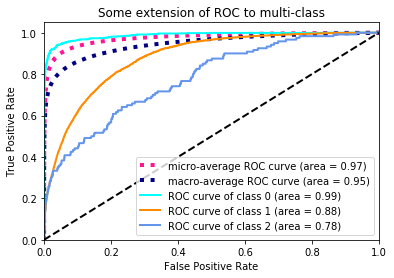

In [102]:
n_classes = len(tags_counts)
roc_auc(y_test_mlb, y_test_predicted_scores_mybag, n_classes)

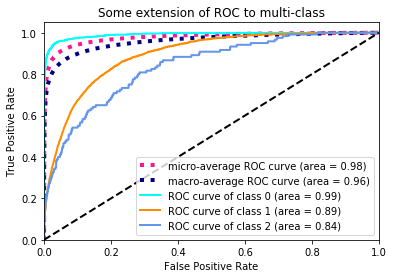

In [103]:
n_classes = len(tags_counts)
roc_auc(y_test_mlb, y_test_predicted_scores_tfidf, n_classes)

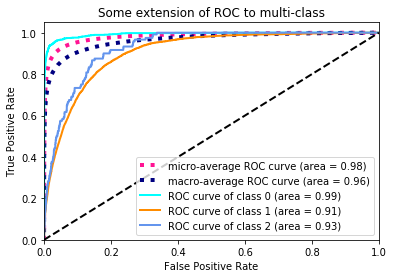

In [104]:
n_classes = len(tags_counts)
roc_auc(y_test_mlb, y_test_predicted_labels_rnn, n_classes)

The F1-weighted score calculates metrics for each label and finds their average weighted by support (number of true instances for each label), which alters 'macro' to account for label imbalance. Therefore, this score is an important evaluation metric for multiclass classification problems with imbalanced labels, and will be used here to evaluate and compare models. 

From the above, RNN performs the best in predicting tags in this multiclass classification problem. It has the highest F1 weighted score of 0.52.

Parameter optimisation will now be performed for the bag-of-words and tf-idf models to see if it improves their performance.

## Improving Model Performance

Hyperparameters can be tuned in order to see if it improves the performance of the classifiers. F1-weighted score will be used to compare performance.

In [105]:
#experimenting with penalty and C value for bag-of-words and tf-idf models
for penalty in ('l1', 'l2'):
    for C in (0.1, 0.6, 1, 3):
        print('Penalty:', penalty, 'C=', C)
        classifier_mybag = train_classifier(X_train_mybag, y_train_mlb, penalty, C)
        classifier_tfidf = train_classifier(X_train_tfidf, y_train_mlb, penalty, C)
        y_test_predicted_labels_mybag = classifier_mybag.predict(X_test_mybag)

        y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_test_tfidf)
        print('Bag-of-words')
        print('F1-score weighted:', f1_score(y_test_mlb, y_test_predicted_labels_mybag, average='weighted'))
        print('Tfidf')
        print('F1-score weighted:', f1_score(y_test_mlb, y_test_predicted_labels_tfidf, average='weighted'))

Penalty: l1 C= 0.1
Bag-of-words
F1-score weighted: 0.4631575290135896
Tfidf
F1-score weighted: 0.45007062145344834
Penalty: l1 C= 0.6
Bag-of-words
F1-score weighted: 0.47766567378449476
Tfidf
F1-score weighted: 0.49001725247091804
Penalty: l1 C= 1
Bag-of-words
F1-score weighted: 0.4799719592482655
Tfidf
F1-score weighted: 0.4980408344510512
Penalty: l1 C= 3
Bag-of-words
F1-score weighted: 0.4837962293968291
Tfidf
F1-score weighted: 0.5064096323528063
Penalty: l2 C= 0.1
Bag-of-words
F1-score weighted: 0.4486308929257405
Tfidf
F1-score weighted: 0.3240017005290428
Penalty: l2 C= 0.6
Bag-of-words
F1-score weighted: 0.4750833583639222
Tfidf
F1-score weighted: 0.44956499202351274
Penalty: l2 C= 1
Bag-of-words
F1-score weighted: 0.47751430710667586
Tfidf
F1-score weighted: 0.4677504773168729
Penalty: l2 C= 3
Bag-of-words
F1-score weighted: 0.4801053577253645
Tfidf
F1-score weighted: 0.48974070107856593


Optimal parameters for the models are C = 3, penalty = l1 for both.

The classifiers will now be trained with optimal parameters, and used to predict the test set tags.

In [106]:
#bag-of-words
final_classifier_mybag = train_classifier(X_train_mybag, y_train_mlb, penalty='l1', C=3)

#predict test labels with final mybag classifier
y_test_predicted_labels_mybag = final_classifier_mybag.predict(X_test_mybag)

print('F1-score weighted for bag-of-words final classifier:', f1_score(y_test_mlb, y_test_predicted_labels_mybag, average='weighted'))

F1-score weighted for bag-of-words final classifier: 0.4838031663642424


In [107]:
#tf-idf
final_classifier_tfidf = train_classifier(X_train_tfidf, y_train_mlb, penalty='l1', C=3)

#predict test labels with final tf-idf classifier
y_test_predicted_labels_tfidf = final_classifier_tfidf.predict(X_test_tfidf)

print('F1-score weighted for TF-IDF final classifier:', f1_score(y_test_mlb, y_test_predicted_labels_tfidf, average='weighted'))

F1-score weighted for TF-IDF final classifier: 0.5064235094802919


This hyperparameter optimisation has improved the performance of the classifiers, increasing the F1 weighted score for the bag-of words model from 0.4775 to 0.4838, and the tf-idf model from 0.4678 to 0.5064. However, the RNN model still performs better with F1 weighted score of 0.5201 (which may be further improved by tuning parameters, but this will not be done here).

Further improvements in performance for all models may have been achieved with the inclusion of the question body as well as the title.

Once again, it should be noted that performance metrics are for the filtered data rather than the original data. As not all tags were retained, for some questions the model would not have predicted all tags that corresponded to the question in the raw data - it would have predicted only those tags that were within the most common 1,000 as that is what it was trained to predict.

With greater computing power, tags and questions would not have been filtered. Steps would have needed to be taken to ensure that every unique tag within the training set was included in the data used to train the model, in order to ensure that the model is capable of predicting these for unseen data that these tags may be appropriate for. Furthermore, keyword identification may have been neccessary to predict tags within unseen data that would not have been present in the training data.

## Analysis of the most important features

The features (words or n-grams) that are used with the largest weights in the logistic regression model for a specified tag can be found by extracting estimators for each tag, and feature coefficients from the estimator, sorting and finding those words with the highest coefficients for the top positive words and the lowest coefficients for the top negative words associated with the tag.

In [108]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 

    coef = classifier.coef_[tags_classes.index(tag)]
    
    top_positive_words = [index_to_words[idx] for idx in coef.argsort()[-1:-6:-1]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[idx] for idx in coef.argsort()[:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [113]:
multilabel_binarizer = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))

print_words_for_tag(classifier_tfidf, 'c', multilabel_binarizer.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', multilabel_binarizer.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', multilabel_binarizer.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, scanf, fscanf, realloc, fgets
Top negative words:	javascript, php, jquery, java, c c

Tag:	c++
Top positive words:	c++, boost, std, cin, cpp
Top negative words:	jquery, php, javascript, java, python

Tag:	linux
Top positive words:	linux, systemd, bash, glibc, nix
Top negative words:	jquery, javascript, c#, linux kernel, ios

